# Download Cataract dataset from kaggle to train our models

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jr2ngb/cataractdataset")

print("Path to dataset files:", path)

c:\Users\shash\OneDrive\Desktop\ai-and-sus\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 3.34G/3.34G [08:29<00:00, 7.04MB/s] 

Extracting files...


Path to dataset files: C:\Users\shash\.cache\kagglehub\datasets\jr2ngb\cataractdataset\versions\2


## Put Dataset in current working directory

In [8]:
import shutil
import os

# Define source and destination paths
dataset_dir  = os.path.join(path, "dataset") 
destination_folder = os.getcwd()  # Get current working directory

# Copy dataset folder
shutil.copytree(dataset_dir , os.path.join(destination_folder, "dataset"))

print(f"Dataset copied to: {os.path.join(destination_folder, 'dataset')}")


Dataset copied to: c:\Users\shash\OneDrive\Desktop\ai-and-sus\dataset


# 1. Import Libraries

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import random

# 2. Set Random Seed

In [5]:
# Set random seed for reproducibility
torch.manual_seed(42)
pd.set_option('display.max_colwidth', None)
random.seed(42)

# 3. Define Data Directories

In [10]:
# Define paths to the training, validation, and test datasets
output_dir = 'output_dataset'  # New directory to store the splits
classes = ['1_normal', '2_cataract', '2_glaucoma', '3_retina_disease']

# Define your split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Remove the output directory if it already exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# Create output directories
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

# Perform the split
for cls in classes:
    class_path = os.path.join(dataset_dir, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    total_images = len(images)
    train_end = int(total_images * train_ratio)
    val_end = train_end + int(total_images * val_ratio)

    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    for image in train_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(output_dir, 'train', cls, image)
        shutil.move(src, dst)

    for image in val_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(output_dir, 'val', cls, image)
        shutil.move(src, dst)

    for image in test_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(output_dir, 'test', cls, image)
        shutil.move(src, dst)

# Define paths to the training, validation, and test datasets
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')


# 4. Data Augmentation and Transformation

In [11]:
# Define transformations for data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Default size for ResNet18 and ViT
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Specific transformation for EfficientNetV2
efficientnet_transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Specific size for EfficientNetV2
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# 5. Create Datasets

In [12]:
# Create datasets for training, validation, and test
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
val_dataset = ImageFolder(root=val_dir, transform=val_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

# Create datasets for EfficientNetV2
efficientnet_train_dataset = ImageFolder(root=train_dir, transform=efficientnet_transform)
efficientnet_val_dataset = ImageFolder(root=val_dir, transform=val_transform)
efficientnet_test_dataset = ImageFolder(root=test_dir, transform=test_transform)

# 6. Create Data Loaders

In [13]:
# Create data loaders for training, validation, and test
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

efficientnet_train_loader = DataLoader(efficientnet_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
efficientnet_val_loader = DataLoader(efficientnet_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
efficientnet_test_loader = DataLoader(efficientnet_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


# 7. Data Inspection

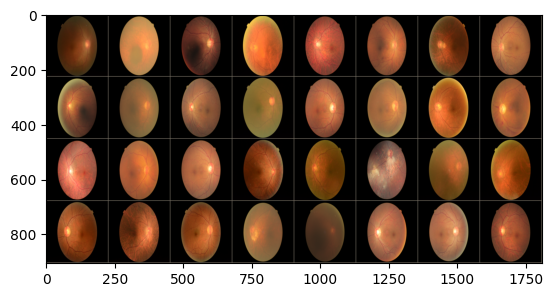

Training dataset size: 420
Validation dataset size: 90
Test dataset size: 91
Number of classes: 4
Class names: ['1_normal', '2_cataract', '2_glaucoma', '3_retina_disease']


In [15]:
# Display sample images from the training dataset
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use next(dataiter) instead of dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))

# Print dataset sizes and class distributions
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Number of classes: {len(train_dataset.classes)}')
print(f'Class names: {train_dataset.classes}')